In [2]:
import pandas as pd

In [3]:
df_bandarban = pd.read_csv('../1980-2024-dataset/Bandarban_historical_weather_1980_2024.csv')

In [4]:
desired_colmn = ['day', 'month', 'year', 'temperature(degree C)', 'humidity']

df_bandarban = df_bandarban[desired_colmn]
df_bandarban.describe()

,day,month,year,temperature(degree C),humidity
count,16437.000000,16437.000000,16437.000000,14764.000000,14764.000000
mean,15.730243,6.522723,2002.000000,26.154403,77.653698
std,8.800616,3.448865,12.988187,3.447506,9.532762
min,1.000000,1.000000,1980.000000,6.100000,8.200000
25%,8.000000,4.000000,1991.000000,23.900000,72.700000
50%,16.000000,7.000000,2002.000000,27.200000,78.900000
75%,23.000000,10.000000,2013.000000,28.700000,83.800000
max,31.000000,12.000000,2024.000000,34.200000,100.000000


In [5]:
with_no_null = df_bandarban.dropna()
print(f"After removing missing values from bandarban, dataset contains {with_no_null.shape[0]} rows and {with_no_null.shape[1]} columns out of {df_bandarban.shape[0]} rows.")
with_no_null.head()

After removing missing values from bandarban, dataset contains 14764 rows and 5 columns out of 16437 rows.


,day,month,year,temperature(degree C),humidity
6,7,1,1980,6.1,41.9
386,21,1,1981,17.6,80.0
731,1,1,1982,17.1,82.5
732,2,1,1982,6.6,70.3
733,3,1,1982,24.1,8.2


In [6]:

# count zeros per column and show as a table
zeros_per_col = (with_no_null == 0).sum()
zeros_df = zeros_per_col.to_frame(name='zero_count')
zeros_df['zero_percentage'] = (zeros_df['zero_count'] / len(with_no_null) * 100).round(2)
zeros_df = zeros_df[zeros_df['zero_count'] > 0].sort_values('zero_count', ascending=False)

print("Number of zeros per column (only columns with > 0 zeros shown):")
display(zeros_df)

# drop rows that contain any 0 or 0.0 and update with_no_null_HI
rows_before = with_no_null.shape[0]
with_no_null_HI = with_no_null[(with_no_null != 0).all(axis=1)]
rows_after = with_no_null_HI.shape[0]
print(f"Dropped {rows_before - rows_after} rows containing zero values. New shape: {with_no_null_HI.shape}")

Number of zeros per column (only columns with > 0 zeros shown):


,zero_count,zero_percentage


Dropped 0 rows containing zero values. New shape: (14764, 5)


# converting to time series

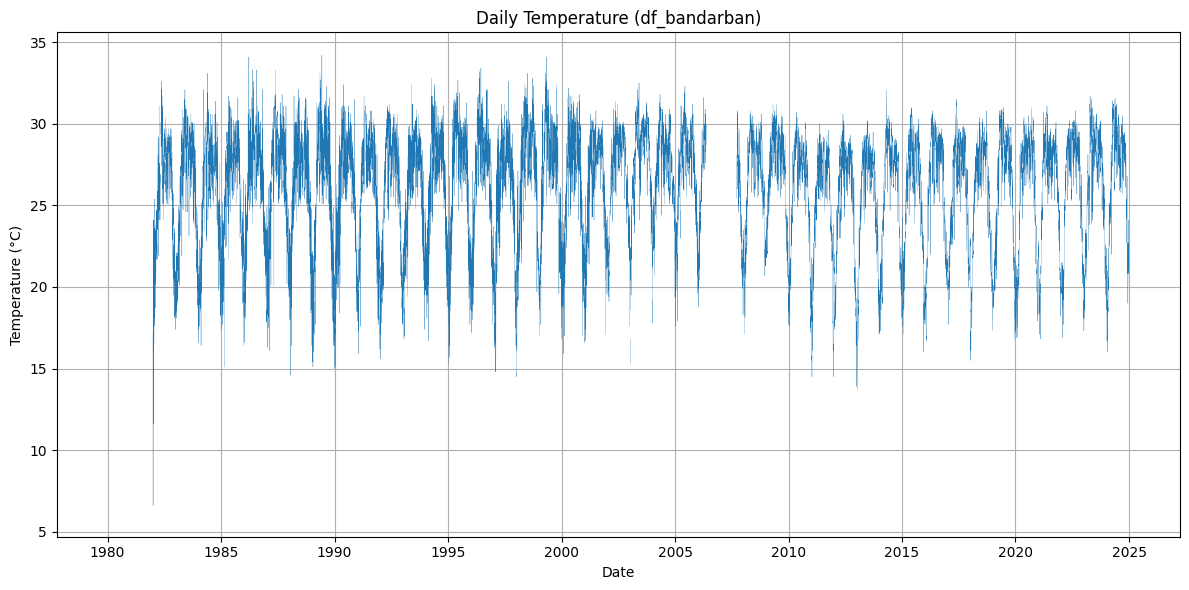

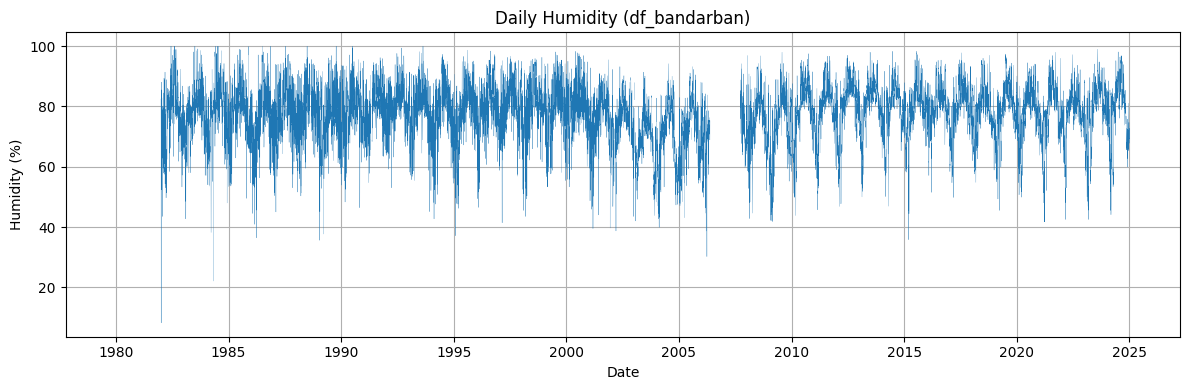

In [23]:
import matplotlib.pyplot as plt

if 'date' not in df_bandarban.columns:
    df_bandarban['date'] = pd.to_datetime(df_bandarban[['year', 'month', 'day']])

min_date = df_bandarban['date'].min()
max_date = df_bandarban['date'].max()

plt.figure(figsize=(12, 6))
plt.plot(df_bandarban['date'], df_bandarban['temperature(degree C)'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Daily Temperature (df_bandarban)')
plt.grid(True)
plt.tight_layout()
plt.show()

# plot daily humidity time series
plt.figure(figsize=(12, 4))
plt.plot(df_bandarban['date'], df_bandarban['humidity'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Daily Humidity (df_bandarban)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
with_no_null.head()

,day,month,year,temperature(degree C),humidity,date
6,7,1,1980,6.1,41.9,1980-01-07
386,21,1,1981,17.6,80.0,1981-01-21
731,1,1,1982,17.1,82.5,1982-01-01
732,2,1,1982,6.6,70.3,1982-01-02
733,3,1,1982,24.1,8.2,1982-01-03


# Random Forest with lagging + rolling

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])


temp_col = 'temperature(degree C)'
hum_col = 'humidity'

desired_col = ['day', 'month', 'year', temp_col, hum_col]

df = df[desired_col].copy()


# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df[temp_col].shift(lag)
    df[f'hum_lag_{lag}'] = df[hum_col].shift(lag)
    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df[temp_col].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df[hum_col].transform(lambda x: x.rolling(window=7).mean())

rolling_cols = ['temp_roll_7', 'hum_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]

FEATURES = ['day', 'month', 'year' ] + fourier_cols + lag_cols + rolling_cols
X = df[FEATURES]
y = pd.DataFrame({
    'temperature': df[temp_col],
    'humidity': df[hum_col]
}).astype(float)    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

targets = y.columns
rf_model = {}
y_preds = {}
rmses = {}
r2s = {}

for target in targets:
    rf_model = RandomForestRegressor(
        n_estimators= 800 ,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
    rf_model.fit(X_train, y_train[target])

    y_pred = rf_model.predict(X_test)


    # model evaluation
    mse_rf = mean_squared_error(y_test[target], y_pred)
    rmse_rf = np.sqrt(mse_rf)
    r2_rf = r2_score(y_test[target], y_pred)

    print(f"\nRandom Forest Results for {target}:")
    print(f'MSE: {mse_rf:.4f}')
    print(f'RMSE: {rmse_rf:.4f}')
    print(f'R² Score: {r2_rf:.4f}')

    # k fold cross-validation 
    # Because you have included lags, "Shuffling" can be dangerous. It causes Data Leakage.

    tscv = TimeSeriesSplit(n_splits=5)

    rmse_list_rf = []
    for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index][target]
        y_test_kf = y.iloc[test_index][target]
        
        rf_model_kf = RandomForestRegressor(
            n_estimators= 800 ,
            random_state=42,
            max_depth=22,
            min_samples_split=2,
            min_samples_leaf=1,
            n_jobs=-1,
            max_features='sqrt'
        )

        rf_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_rf = rf_model_kf.predict(X_test_kf)

        mse_kf_rf = mean_squared_error(y_test_kf, y_pred_kf_rf)
        rmse_kf_rf = np.sqrt(mse_kf_rf)
        rmse_list_rf.append(rmse_kf_rf)
        average_rmse_rf = np.mean(rmse_list_rf)
        r2_kf_rf = r2_score(y_test_kf, y_pred_kf_rf)

    print(f"Average RMSE from K-Fold CV (Random Forest): {average_rmse_rf:.4f}")
    print(f"RMSEs from each fold (Random Forest): {rmse_list_rf}")
    print(f"K fold R²   : {r2_kf_rf:.4f}")
    print(f"K fold MSE  : {mse_kf_rf:.4f}")
    
# Feature importance for Random Forest
    importance = rf_model.feature_importances_
    feature_names = X.columns
    feature_importance_df_rf = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df_rf = feature_importance_df_rf.sort_values(by='Importance', ascending=False)
    print("\nRandom Forest Feature Importances:")
    print(feature_importance_df_rf)


# when n = 3 
# temperature: RMSE=1.3715, R²=0.8349, MSE=1.8810
# temperature: CV RMSE=1.4089 ± 0.0241
# temperature: CV R²=0.8401, CV MSE=2.0237
# humidity: RMSE=6.5602, R²=0.5356, MSE=43.0362 
# humidity: CV RMSE=6.6293 ± 0.1343
# humidity: CV R²=0.4863, CV MSE=46.6283

### wtih out shuffling in kfold

# (lagging + rolling) 
# Temp [R2: 0.8920, K fold R² : 0.9404]
# humidity [ R2: 0.6663, K fold R² : 0.7572]

#  only lagging
# Temp [R2: 0.8719, K fold R² : 0.9293]
# humidity [ R2: 0.6247, K fold R² : 0.7236]


Random Forest Results for temperature:
MSE: 1.3209
RMSE: 1.1493
R² Score: 0.8921
Average RMSE from K-Fold CV (Random Forest): 1.0818
RMSEs from each fold (Random Forest): [np.float64(1.3564844659668034), np.float64(1.301058648786802), np.float64(0.9704305830864425), np.float64(0.9098054740521943), np.float64(0.8714232103546347)]
K fold R²   : 0.9408
K fold MSE  : 0.7594

Random Forest Feature Importances:
              Feature  Importance
15        temp_roll_7    0.301415
9          temp_lag_1    0.219331
11         temp_lag_2    0.162753
13         temp_lag_3    0.130789
1               month    0.061878
16         hum_roll_7    0.021802
10          hum_lag_1    0.015363
14          hum_lag_3    0.014439
12          hum_lag_2    0.012932
5   day_of_year_sin_2    0.009299
4   day_of_year_cos_1    0.008255
3   day_of_year_sin_1    0.007731
2                year    0.007697
8   day_of_year_cos_3    0.007342
7   day_of_year_sin_3    0.006551
6   day_of_year_cos_2    0.006334
0           

# tolerance testing for the random forest model

In [27]:
# tolerance testing for the random forest model
tolerances = [0.01, 0.05, 0.1, 0.2, 0.3]
results = []
for tol in tolerances:
    rf_model_temp = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
    rf_model_temp.fit(X_train, y_train['temperature'])

    y_pred_temp = rf_model_temp.predict(X_test)
    
    rf_model_hum = RandomForestRegressor(
        n_estimators=800,
        random_state=42,
        max_depth=22,
        min_samples_split=2,
        min_samples_leaf=1,
        n_jobs=-1,
        max_features='sqrt'
    )
    rf_model_hum.fit(X_train, y_train['humidity'])

    y_pred_hum = rf_model_hum.predict(X_test)
    
    # Apply tolerance
    y_pred_temp_tol = np.where(np.abs(y_pred_temp - y_test['temperature']) <= tol, y_test['temperature'], y_pred_temp)
    y_pred_hum_tol = np.where(np.abs(y_pred_hum - y_test['humidity']) <= tol, y_test['humidity'], y_pred_hum)
    
    mse_temp = mean_squared_error(y_test['temperature'], y_pred_temp_tol)
    rmse_temp = np.sqrt(mse_temp)
    r2_temp = r2_score(y_test['temperature'], y_pred_temp_tol)
    
    mse_hum = mean_squared_error(y_test['humidity'], y_pred_hum_tol)
    rmse_hum = np.sqrt(mse_hum)
    r2_hum = r2_score(y_test['humidity'], y_pred_hum_tol)
    
    results.append({
        'tolerance': tol,
        'rmse_temp': rmse_temp,
        'r2_temp': r2_temp,
        'mse_temp': mse_temp,
        'rmse_hum': rmse_hum,
        'r2_hum': r2_hum,
        'mse_hum': mse_hum
    })


# Display results in a DataFrame
results_df = pd.DataFrame(results)
print("\nTolerance Testing Results:")
print(results_df)


Tolerance Testing Results:
   tolerance  rmse_temp   r2_temp  mse_temp  rmse_hum    r2_hum    mse_hum
0       0.01   1.149319  0.892135  1.320934  5.539287  0.665441  30.683705
1       0.05   1.149303  0.892138  1.320898  5.539287  0.665441  30.683696
2       0.10   1.149181  0.892160  1.320617  5.539283  0.665442  30.683652
3       0.20   1.148443  0.892299  1.318921  5.539250  0.665446  30.683289
4       0.30   1.146431  0.892676  1.314303  5.539145  0.665458  30.682128


In [28]:
# separate rf_model for temp and hum into rf_model_temp and rf_model_hum from rf_model = {}
# If you have a dictionary of models from your training loop:
rf_model_temp = rf_model[0]
rf_model_hum = rf_model[1]

print(rf_model_temp)
print(rf_model_hum)


DecisionTreeRegressor(max_depth=22, max_features='sqrt',
                      random_state=1608637542)
DecisionTreeRegressor(max_depth=22, max_features='sqrt',
                      random_state=1273642419)


# LSTM-RF hybridization

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

def create_sequences(x_data, y_data, window_size=5):
    X_seq, y_seq = [], []
    for i in range(window_size, len(x_data)):
        X_seq.append(x_data[i-window_size:i]) # Grab the previous 'n' days
        y_seq.append(y_data[i])               # The error of the CURRENT day
    return np.array(X_seq), np.array(y_seq)

# 1. Chronological Split (No Shuffling!)
train_size = int(len(df) * 0.8)

# These keep their column names (Good for RF)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# 2. Re-fit your RF models on X_train explicitly to ensure they "own" the names
rf_model_temp.fit(X_train, y_train['temperature'])
rf_model_hum.fit(X_train, y_train['humidity'])

# Get predictions on the training set using the DataFrames
train_preds_temp = rf_model_temp.predict(X_train)
train_preds_hum = rf_model_hum.predict(X_train)

# Calculate Residuals (Errors)
res_temp = y_train['temperature'].values - train_preds_temp
res_hum = y_train['humidity'].values - train_preds_hum

# Combine into a single error target for the LSTM
train_residuals = np.column_stack([res_temp, res_hum])

# 1. Scale the features for the LSTM
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)



# --- NEW SLIDING WINDOW BLOCK ---
window_size = 5  # You can try 3, 5, or 7

# Create sequences for training
X_train_lstm, train_residuals_seq = create_sequences(X_train_scaled, train_residuals, window_size)

# Create sequences for testing
X_test_lstm, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# Update the LSTM Input Shape
lstm_model = Sequential([
    Input(shape=(window_size, X_train_lstm.shape[2])), # Updated: shape is now (5, features)
    LSTM(32, activation='tanh'), 
    Dense(16, activation='relu'),
    Dense(2) 
])
# Note: Use train_residuals_seq here instead of train_residuals
lstm_model.compile(optimizer='adam', loss='mae')
lstm_model.fit(X_train_lstm, train_residuals_seq, epochs=40, batch_size=32, verbose=0)

# --- UPDATED PREDICTION BLOCK ---
# We skip the first 'window_size' rows of X_test to match the LSTM output
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# Get RF predictions on the ALIGNED test set
rf_t_pred = rf_model_temp.predict(X_test_aligned)
rf_h_pred = rf_model_hum.predict(X_test_aligned)

# Get LSTM corrections (These will already be aligned because of create_sequences)
corrections = lstm_model.predict(X_test_lstm)

# Combine
final_temp = rf_t_pred + corrections[:, 0]
final_hum = rf_h_pred + corrections[:, 1]

print(f"Windowed Temp R2: {r2_score(y_test_aligned['temperature'], final_temp):.4f}")
print(f"Windowed Hum R2: {r2_score(y_test_aligned['humidity'], final_hum):.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Windowed Temp R2: 0.8283
Windowed Hum R2: 0.3156


In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from sklearn.metrics import mean_squared_error, r2_score
from keras.optimizers import Adam, SGD

# --- STEP 1: Selective Features for LSTM ---
# We only give the LSTM the most important "weather" features to reduce noise
lstm_feature_cols = lag_cols + rolling_cols 
X_train_slim = X_train[lstm_feature_cols]
X_test_slim = X_test[lstm_feature_cols]

scaler_slim = StandardScaler()
X_train_scaled = scaler_slim.fit_transform(X_train_slim)
X_test_scaled = scaler_slim.transform(X_test_slim)

# --- STEP 2: Create Sequences ---
window_size = 7 # Try a full week
X_train_seq, y_train_res_seq = create_sequences(X_train_scaled, train_residuals, window_size)
X_test_seq, _ = create_sequences(X_test_scaled, np.zeros((len(X_test_scaled), 2)), window_size)

# --- STEP 3: Optimized LSTM ---
lstm_model = Sequential([
    Input(shape=(window_size, X_train_scaled.shape[1])),
    LSTM(100, activation='tanh', return_sequences=True), # Return sequences for deeper learning
    LSTM(50, activation='tanh'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2) 
])

# Use a slightly slower learning rate to find the pattern

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='huber') # Huber loss is great for weather outliers
lstm_model.fit(X_train_seq, y_train_res_seq, epochs=60, batch_size=64, verbose=0)

# 1. Align the Test Data (Skip the first 7 days used for the window)
X_test_aligned = X_test.iloc[window_size:]
y_test_aligned = y_test.iloc[window_size:]

# 2. Get the "Base" predictions from your Random Forest
rf_t_pred = rf_model_temp.predict(X_test_aligned)
rf_h_pred = rf_model_hum.predict(X_test_aligned)

# 3. Get the "Corrections" from the LSTM
# X_test_seq was created during your sequence step
lstm_corrections = lstm_model.predict(X_test_seq)

# 4. Combine them: Base + Correction
final_temp = rf_t_pred + lstm_corrections[:, 0]
final_hum = rf_h_pred + lstm_corrections[:, 1]

# 5. Output the New Results
print("--- HYBRID MODEL PERFORMANCE ---")
print(f"Final Temp R2: {r2_score(y_test_aligned['temperature'], final_temp):.4f}")
print(f"Final Hum R2: {r2_score(y_test_aligned['humidity'], final_hum):.4f}")

86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
--- HYBRID MODEL PERFORMANCE ---
Final Temp R2: 0.8285
Final Hum R2: 0.3159


# XGBoost 

In [37]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

df = df_bandarban.copy()
if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

temp_col = 'temperature(degree C)'
hum_col = 'humidity'

desired_col = ['day', 'month', 'year', temp_col, hum_col]

df = df[desired_col].copy()

# adding lagging for 3 days
lags = [1, 2, 3]
lag_cols = []

for lag in lags:
    df[f'temp_lag_{lag}'] = df[temp_col].shift(lag)
    df[f'hum_lag_{lag}'] = df[hum_col].shift(lag)
    lag_cols.extend([f'temp_lag_{lag}', f'hum_lag_{lag}'])

# 7-day Rolling Average
df['temp_roll_7'] = df[temp_col].transform(lambda x: x.rolling(window=7).mean())
df['hum_roll_7'] = df[hum_col].transform(lambda x: x.rolling(window=7).mean())

rolling_cols = ['temp_roll_7', 'hum_roll_7']


df = df.dropna().reset_index(drop=True)


df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').reset_index(drop=True)

df['day_of_year'] = df['date'].dt.dayofyear

def add_fourier_features(df,col,period,n_terms=3):
    for n in range(1, n_terms + 1):
        df[f'{col}_sin_{n}'] = np.sin(2 * np.pi * n * df.index / period)
        df[f'{col}_cos_{n}'] = np.cos(2 * np.pi * n * df.index / period)
    return df

df = add_fourier_features(df, 'day_of_year', period=365, n_terms=3)
fourier_cols = [c for c in df.columns if c.startswith('day_of_year_sin') or c.startswith('day_of_year_cos')]

FEATURES = ['day', 'month', 'year' ] + fourier_cols + lag_cols + rolling_cols
X = df[FEATURES]
y = pd.DataFrame({
    'temperature': df[temp_col],
    'humidity': df[hum_col]
}).astype(float)    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

targets = y.columns
xgb_model = {}
y_preds = {}
rmses = {}
r2s = {}

for target in targets:
    xgb_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    xgb_model.fit(X_train, y_train[target])

    y_pred = xgb_model.predict(X_test)

    mse_xgb = mean_squared_error(y_test[target], y_pred)
    rmse_xgb = np.sqrt(mse_xgb)
    r2_xgb = r2_score(y_test[target], y_pred)


    print(f"\nXGBoost Results for {target}:")
    print(f'Mean Squared Error: {mse_xgb:.4f}')
    print(f'RMSE: {rmse_xgb:.4f}')
    print(f'R² Score: {r2_xgb:.4f}')


    # K-Fold cross-validation for XGBoost
    tscv = TimeSeriesSplit(n_splits=5)

    rmse_list_xgb = []
    for train_index, test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index][target]
        y_test_kf = y.iloc[test_index][target]

        xgb_model_kf = xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=800,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        xgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_xgb = xgb_model_kf.predict(X_test_kf)


        mse_kf_xgb = mean_squared_error(y_test_kf, y_pred_kf_xgb)
        rmse_kf_xgb = np.sqrt(mse_kf_xgb)
        rmse_list_xgb.append(rmse_kf_xgb)
        average_rmse_xgb = np.mean(rmse_list_xgb)
        r2_kf_xgb = r2_score(y_test_kf, y_pred_kf_xgb)

    print(f"Average MSE from K-Fold CV (XGBoost): {average_rmse_xgb:.4f}")
    print(f"MSEs from each fold (XGBoost): {rmse_list_xgb}")
    print(f"K fold R²   : {r2_kf_xgb:.4f}")
    print(f"K fold MSE  : {mse_kf_xgb:.4f}")
    
# Feature importance for XGBoost
    importance = xgb_model.feature_importances_
    feature_names = X.columns
    feature_importance_df_xgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='Importance', ascending=False)
    print("\nXGBoost Feature Importances:")
    print(feature_importance_df_xgb)

# (lagging + rolling) xgb
# Temp [R2: 0.8920, K fold R² : 0.9330]
# humidity [ R2: 0.6549, K fold R² : 0.7350]


XGBoost Results for temperature:
Mean Squared Error: 1.3567
RMSE: 1.1648
R² Score: 0.8892
Average MSE from K-Fold CV (XGBoost): 1.1484
MSEs from each fold (XGBoost): [np.float64(1.4002572597165768), np.float64(1.3836373847114103), np.float64(1.0793236159616508), np.float64(0.9515023743775518), np.float64(0.9274782624287756)]
K fold R²   : 0.9330
K fold MSE  : 0.8602

XGBoost Feature Importances:
              Feature  Importance
15        temp_roll_7    0.803388
9          temp_lag_1    0.098677
13         temp_lag_3    0.010042
1               month    0.009018
10          hum_lag_1    0.008398
6   day_of_year_cos_2    0.007377
16         hum_roll_7    0.007361
2                year    0.006331
5   day_of_year_sin_2    0.006148
7   day_of_year_sin_3    0.005964
12          hum_lag_2    0.005925
4   day_of_year_cos_1    0.005907
8   day_of_year_cos_3    0.005791
14          hum_lag_3    0.005656
11         temp_lag_2    0.005609
3   day_of_year_sin_1    0.005041
0                 day 

In [14]:
# tolerance testing using xgboost
tolerances = [0.01, 0.05, 0.1, 0.2, 0.3]
results = []

for tol in tolerances:
    xgb_model_temp = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    xgb_model_temp.fit(X_train, y_train['temperature'])
    y_pred_temp = xgb_model_temp.predict(X_test)

    xgb_model_hum = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=800,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    xgb_model_hum.fit(X_train, y_train['humidity'])
    
    y_pred_hum = xgb_model_hum.predict(X_test)
    # Apply tolerance
    y_pred_temp_tol = np.where(np.abs(y_pred_temp - y_test['temperature']) <= tol, y_test['temperature'], y_pred_temp)
    y_pred_hum_tol = np.where(np.abs(y_pred_hum - y_test['humidity']) <= tol, y_test['humidity'], y_pred_hum)
    mse_temp = mean_squared_error(y_test['temperature'], y_pred_temp_tol)
    rmse_temp = np.sqrt(mse_temp)
    r2_temp = r2_score(y_test['temperature'], y_pred_temp_tol)
    mse_hum = mean_squared_error(y_test['humidity'], y_pred_hum_tol)
    rmse_hum = np.sqrt(mse_hum)
    r2_hum = r2_score(y_test['humidity'], y_pred_hum_tol)
    results.append({
        'tolerance': tol,
        'rmse_temp': rmse_temp,
        'r2_temp': r2_temp,
        'mse_temp': mse_temp,
        'rmse_hum': rmse_hum,
        'r2_hum': r2_hum,
        'mse_hum': mse_hum
    })


# Display results in a DataFrame
results_df = pd.DataFrame(results)
print("\nTolerance Testing Results:")
print(results_df)




Tolerance Testing Results:
   tolerance  rmse_temp   r2_temp  mse_temp  rmse_hum    r2_hum    mse_hum
0       0.01   1.164784  0.889212  1.356721  5.626271  0.654851  31.654924
1       0.05   1.164769  0.889215  1.356687  5.626270  0.654852  31.654914
2       0.10   1.164668  0.889234  1.356453  5.626266  0.654852  31.654864
3       0.20   1.163840  0.889392  1.354524  5.626224  0.654857  31.654392
4       0.30   1.161484  0.889839  1.349046  5.626121  0.654870  31.653242


# Light GBM

In [34]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

targets = y.columns
lgb_model = {}
y_preds = {}
rmses = {}
r2s = {}

for target in targets:
    lgb_model = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.01,
        max_depth=22,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42
    )

    lgb_model.fit(X_train, y_train[target])

    y_pred = lgb_model.predict(X_test)

    mse_lgb = mean_squared_error(y_test[target], y_pred)
    rmse_lgb = np.sqrt(mse_lgb)
    r2_lgb = r2_score(y_test[target], y_pred)

    print(f"\nXGBoost Results for {target}:")
    print(f'Mean Squared Error: {mse_lgb:.4f}')
    print(f'RMSE: {rmse_lgb:.4f}')
    print(f'R² Score: {r2_lgb:.4f}')

    # --- 6) 5-fold CV R^2 ---
    tscv = TimeSeriesSplit(n_splits=5)
    
    rmse_list_lgb = []
    for train_index,test_index in tscv.split(X):
        X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
        y_train_kf = y.iloc[train_index][target]
        y_test_kf = y.iloc[test_index][target]

        lgb_model_kf = lgb.LGBMRegressor(
            n_estimators=500,
            learning_rate=0.01,
            max_depth=22,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=42
        )

        lgb_model_kf.fit(X_train_kf, y_train_kf)
        y_pred_kf_lgb = lgb_model_kf.predict(X_test_kf)

        mse_kf_lgb = mean_squared_error(y_test_kf, y_pred_kf_lgb)
        rmse_kf_lgb = np.sqrt(mse_kf_lgb)
        rmse_list_lgb.append(rmse_kf_lgb)
        average_rmse_lgb = np.mean(rmse_list_lgb)
        r2_kf_lgb = r2_score(y_test_kf, y_pred_kf_lgb)

    print(f"Average MSE from K-Fold CV (XGBoost): {average_rmse_lgb:.4f}")
    print(f"MSEs from each fold (XGBoost): {rmse_list_lgb}")
    print(f"K fold R²   : {r2_kf_lgb:.4f}")
    print(f"K fold MSE  : {mse_kf_lgb:.4f}")

# Feature importance for XGBoost
    importance = lgb_model.feature_importances_
    feature_names = X.columns
    feature_importance_df_lgb = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
    feature_importance_df_lgb = feature_importance_df_lgb.sort_values(by='Importance', ascending=False)
    print("\nXGBoost Feature Importances:")
    print(feature_importance_df_lgb)

# (lagging + rolling) lgb
# Temp [R2: 0.8948, K fold R² : 0.9416]
# humidity [ R2: 0.6736, K fold R² : 0.7635]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3406
[LightGBM] [Info] Number of data points in the train set: 10988, number of used features: 17
[LightGBM] [Info] Start training from score 26.109155

XGBoost Results for temperature:
Mean Squared Error: 1.2879
RMSE: 1.1349
R² Score: 0.8948
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3300
[LightGBM] [Info] Number of data points in the train set: 2290, number of used features: 17
[LightGBM] [Info] Start training from score 25.841179
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3341
[LightGBM] [Info] Number of 

In [ ]:
# # tolerance testing using xgboost
# tolerances = [0.01, 0.05, 0.1, 0.2, 0.3]
# results = []

# for tol in tolerances:
#     lgb_model_temp = xgb.XGBRegressor(
#         n_estimators=500,
#         learning_rate=0.01,
#         max_depth=22,
#         subsample=0.9,
#         colsample_bytree=0.9,
#         random_state=42
#     )
#     lgb_model_temp.fit(X_train, y_train['temperature'])
#     y_pred_temp = lgb_model_temp.predict(X_test)

#     xgb_model_hum = xgb.XGBRegressor(
#         n_estimators=500,
#         learning_rate=0.01,
#         max_depth=22,
#         subsample=0.9,
#         colsample_bytree=0.9,
#         random_state=42
#     )
#     xgb_model_hum.fit(X_train, y_train['humidity'])
    
#     y_pred_hum = xgb_model_hum.predict(X_test)
#     # Apply tolerance
#     y_pred_temp_tol = np.where(np.abs(y_pred_temp - y_test['temperature']) <= tol, y_test['temperature'], y_pred_temp)
#     y_pred_hum_tol = np.where(np.abs(y_pred_hum - y_test['humidity']) <= tol, y_test['humidity'], y_pred_hum)
#     mse_temp = mean_squared_error(y_test['temperature'], y_pred_temp_tol)
#     rmse_temp = np.sqrt(mse_temp)
#     r2_temp = r2_score(y_test['temperature'], y_pred_temp_tol)
#     mse_hum = mean_squared_error(y_test['humidity'], y_pred_hum_tol)
#     rmse_hum = np.sqrt(mse_hum)
#     r2_hum = r2_score(y_test['humidity'], y_pred_hum_tol)
#     results.append({
#         'tolerance': tol,
#         'rmse_temp': rmse_temp,
#         'r2_temp': r2_temp,
#         'mse_temp': mse_temp,
#         'rmse_hum': rmse_hum,
#         'r2_hum': r2_hum,
#         'mse_hum': mse_hum
#     })


# # Display results in a DataFrame
# results_df = pd.DataFrame(results)
# print("\nTolerance Testing Results:")
# print(results_df)




Tolerance Testing Results:
   tolerance  rmse_temp   r2_temp  mse_temp  rmse_hum    r2_hum    mse_hum
0       0.01   1.164013  0.889359  1.354927  5.644021  0.652670  31.854970
1       0.05   1.163998  0.889362  1.354892  5.644020  0.652670  31.854958
2       0.10   1.163905  0.889379  1.354675  5.644016  0.652671  31.854918
3       0.20   1.163207  0.889512  1.353051  5.643981  0.652675  31.854519
4       0.30   1.160994  0.889932  1.347907  5.643889  0.652686  31.853485
